In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import geopandas as gpd
import plotly.express as px
from matplotlib.ticker import FuncFormatter

# option to save figures
save_fig = False

# Data load and preprocessing

In [2]:
# load in data
df = pd.read_pickle('data/cleaned_data_boligsiden.pkl')

# Filter out the types of listings we are interested in
df = df.loc[df['addressType'].isin(['villa','condo','villa apartment',])].reset_index(drop=True)

# Define the regex pattern
pattern = r'^(?P<roadname>[a-zA-ZæøåÆØÅ]+(?:-[a-zA-ZæøåÆØÅ]+)*?)-(?P<housenumber>\d+[a-zA-Z]?(?:-\d+)?[a-zA-Z]?)-(?P<postalcode>\d+)-(?P<city>[a-zA-ZæøåÆØÅ]+(?:-[a-zA-ZæøåÆØÅ]+)*)'
# Apply regex to extract the components
df[['roadname', 'housenumber', 'postalcode', 'city']] = df['slug'].str.extract(pattern)

# fill in the missing postalcode
df.loc[df['roadname'].isnull(), 'postalcode'] = df.loc[df['roadname'].isnull(), 'slug'].str.extract(r'(?P<postalcode>\b\d{4}\b)')


### Remove outliers

In [3]:
df_cut = df.groupby('postalcode').agg({'perAreaPrice':['mean','std','count']}).sort_values(('perAreaPrice','count'), ascending=True)
df_cut.columns = ['mean', 'std', 'count']
df_cut['cut_off'] = df_cut['mean'] - 2*df_cut['std']

df['cut_off'] = df['postalcode'].map(df_cut['cut_off'].to_dict())
df = df.loc[df['perAreaPrice'] > df['cut_off'],:]

# remove rows with missing energy labels since they are not useful
df = df.loc[~df['energyLabel'].isna()]


### Create dummy variables and categories energy labels and addressType

In [4]:
# create dummies for the number of rooms
df['ameneties'] =np.where(df['hasElevator'] | df['hasBalcony'] | df['hasTerrace'], 1, 0)
# turn bool to int
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int)
    
# create dummies for the number of rooms
df['beddroom2-'] = np.where(df['numberOfRooms'] < 3, 1, 0)
df['beedroom3'] = np.where(df['numberOfRooms'] == 3, 1, 0)
df['beedroom4+'] = np.where(df['numberOfRooms'] > 3, 1, 0)

# create dummies for the number of rooms
df['isAppartment'] = np.where(df['addressType']=='condo', 1, 0)

### Category variables
# remove weird energy labels such as a2020 and replace with a
df['energyLabel'] = df['energyLabel'].str.extract(r'([a-zA-Z])')

# turn energy label into a categorical variable
df['energyLabel_cat'] = pd.Categorical(df['energyLabel'], categories=['a','b','c','d','e','f','g'], ordered=True)
df['energyLabel_cat'] = df['energyLabel_cat'].cat.codes 


df['addressType_cat'] = pd.Categorical(df['addressType'], categories=['villa','villa apartment','condo'], ordered=True)
df['addressType_cat'] = df['addressType_cat'].cat.codes


### Merge bus and metro stops and distance to Rådhuspladsen

In [5]:
### Distance to Rådhuspladsen
with open('data/dist_to_raedhus.json', 'r') as f:
    dist_to_raedhus = eval(f.read())

df['distance_to_raedhus'] = df['coordinates'].map(dist_to_raedhus)

### Bus
with open('data/nearest_dict.json','r') as f:
    nearest_dict = eval(f.read())

df['busstop_data'] = df['coordinates'].map(nearest_dict)
df['closest_busstop_in_km'] = df['busstop_data'].apply(lambda x: x['Nearest']['Balltree distance'] if x is not None else None)
df['no_of_stops_in_500m'] = df['busstop_data'].apply(lambda x: x['Radius']['no_of_stops'] if x is not None else None)
df['no_of_unique_stops_in_500m'] = df['busstop_data'].apply(lambda x: len(x['Radius']['bus_lines']) if x is not None else None)
df.drop(columns=['busstop_data'], inplace=True)

### Metro
with open('data/nearest_metro_dict.json','r') as f:
    nearest_dict = eval(f.read())

df['metro_data'] = df['coordinates'].map(nearest_dict)
df['closest_metro_in_km'] = df['metro_data'].apply(lambda x: x['Nearest']['Balltree distance'] if x is not None else None)
df['no_of_metro_in_500m'] = df['metro_data'].apply(lambda x: x['Radius']['no_of_stops'] if x is not None else None)
df.drop(columns=['metro_data'], inplace=True)

# combine closest bus and metro into one variable by selecting the closest
df['clost_public_trans'] = df[['closest_busstop_in_km','closest_metro_in_km']].min(axis=1)
df['no_of_tot_stops_in_500m'] = df['no_of_stops_in_500m'] + df['no_of_metro_in_500m']

# Preview the data
df[['distance_to_raedhus','closest_busstop_in_km', 'no_of_stops_in_500m', 'no_of_unique_stops_in_500m','closest_metro_in_km','no_of_metro_in_500m']].head(5)

,distance_to_raedhus,closest_busstop_in_km,no_of_stops_in_500m,no_of_unique_stops_in_500m,closest_metro_in_km,no_of_metro_in_500m
0,5.933455,0.161385,2,3,1.667620,0
1,1.051302,0.091202,6,11,0.417893,1
2,5.193404,0.165919,7,4,1.362030,0
3,5.977920,0.479571,1,3,2.199132,0
4,1.899647,0.352909,5,4,0.141256,1


# Regressions

## Distributions of the target variable

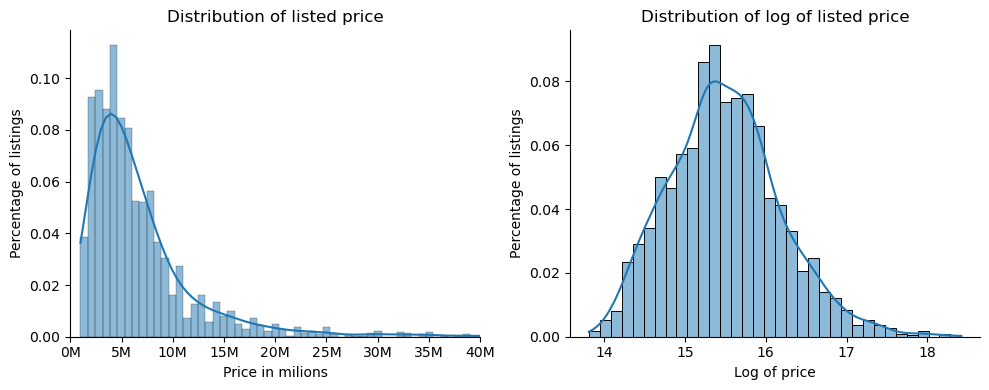

In [6]:
def thousand(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.0fM' % (x * 1e-6)

thousand_formatter = FuncFormatter(thousand)
milion_formatter = FuncFormatter(millions)

def change_format(ax, formatter,title,xlabel:str=None,ylabel:str=None):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    # ax.set_yticks([])
    if formatter is not None:
        ax.xaxis.set_major_formatter(formatter)
    if title is not None:
        ax.set_title(title)


# Create 2x2 plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(df['priceCash'], ax=ax[0], kde=True, stat='probability')
change_format(ax[0], milion_formatter, 'Distribution of listed price',xlabel='Price in milions',ylabel='Percentage of listings')
ax[0].set_xlim(0, 4e7)

sns.histplot(np.log(df['priceCash']), ax=ax[1], kde=True, stat='probability')
change_format(ax[1], None, 'Distribution of log of listed price',xlabel='Log of price',ylabel='Percentage of listings')


fig.tight_layout()
if save_fig:
    fig.savefig('figs/targetVariable_dist.png', dpi=300)

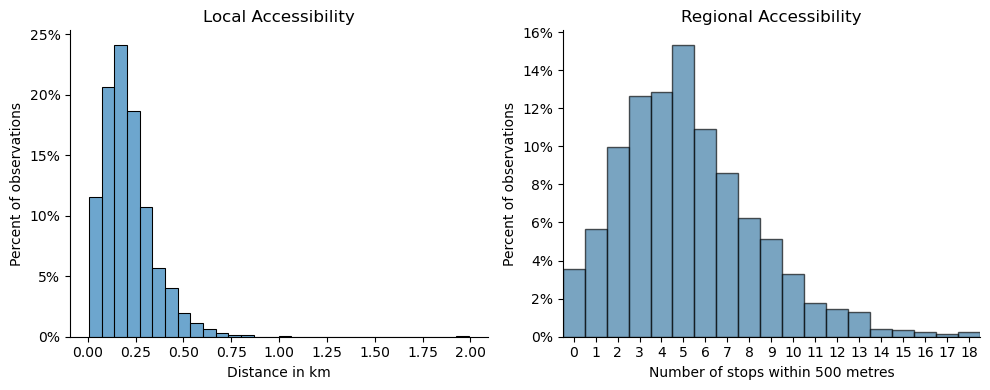

In [7]:
# Create 2x2 plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

def change_format(ax, formatter,title,xlabel:str=None,ylabel:str=None):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    # percentage on y-axis
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    if title is not None:
        ax.set_title(title)

extracted_color = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.5)

sns.histplot(df['clost_public_trans'], ax=ax[0],color=extracted_color,stat='probability',bins=30, alpha=0.65, edgecolor='black')
change_format(ax[0], None, 'Local Accessibility', xlabel='Distance in km',ylabel='Percent of observations')


sns.countplot(df, x='no_of_tot_stops_in_500m', ax=ax[1],color=extracted_color, edgecolor='black',alpha=0.65,stat='probability',width=1)
change_format(ax[1], None, 'Regional Accessibility', xlabel='Number of stops within 500 metres',ylabel='Percent of observations')


fig.tight_layout()
if save_fig:
    fig.savefig('figs/dist_transit.png', dpi=300)

## Simple OLS regression

In [8]:
target_variables = ['priceCash']
public_transport = ['clost_public_trans','no_of_tot_stops_in_500m']
control_variables = ['housingArea','isAppartment','hasBalcony', 'hasElevator','hasTerrace', 'energyLabel_cat']

def ols_regression(df, x_vars, y_var, y_log=False,constant=True, verbose:int=1):
    if verbose:
        print(f'Running OLS regression with {y_var} as the dependent variable and {x_vars} as the independent variables')
    if isinstance(x_vars, list):
        X = df[x_vars]
    else:
        X = x_vars
    if constant:
        X = sm.add_constant(X)
    
    y = df[y_var]
    if y_log:
        y = np.log(y)
    model = sm.OLS(y, X).fit(cov_type='HC3')
    
    return model

def test_for_heteroscedasticity(res):
    name = ["LM statistic", "lm: p-value", "f-value", "f: p-value"]
    test = sms.het_breuschpagan(res.resid, res.model.exog)
    hp = {}
    for n, t in zip(name, test):
        hp[n] = t
    bptest = pd.DataFrame([hp]).T
    print(bptest)
    if bptest.iloc[-1,0]<0.05:
        print('Model shows heteroscedasticity.')
    else: 
        print('Model does not show heteroscedasticity.')

def transform_output(res, x_vars,constant=True):
    """ Transform the output of the OLS regression into a pandas dataframe
            Args:
                res: statsmodels regression output
                x_vars: list of independent variables
                constant: boolean indicating if a constant was added
            Returns:
                output: pandas dataframe with the results"""
    index = ['const'] + x_vars if constant else x_vars

    output = (pd.DataFrame(index=index,
                            data=({
                                'coef':res.params,
                                'std err': res.bse,
                                't-values':res.tvalues,
                                'p-values':res.pvalues,
                                'conf-int1':res.conf_int()[0],
                                'conf-int2':res.conf_int()[1],
                                'significant': ['*' if val < 0.05 else '' for val in res.pvalues]
                                })))
    return output

# Function to determine spacing based on the length of the index
def calculate_spacing(index_length, base_length=30, min_spaces=2):
    # Calculate spaces needed: fewer spaces for long index names, more for short names
    spaces_needed = max(min_spaces, base_length - index_length)
    return ' ' * spaces_needed

def multiple_to_latex(outputs, names, filename='combined_output.tex'):


    output = pd.concat(outputs, axis=1)
    names = output.columns.levels[0]
    output.index = output.index.str.replace('_','\_')
    output['index length'] = output.index.str.len()
    max_length_idx = max(output['index length'])+2

    with open(f'tables/{filename}.tex', 'w') as f:
        f.write(' & ' + ' & '.join([f'\\textbf{{{name}}}' for name in names]) + ' \\\\\n')  
        f.write('\midrule \\\\\n')    
        for idx,row in output.iterrows():
            # Calculate the spacing based on the coefficient length
            idx_spacing = calculate_spacing(len(str(idx)), base_length=max_length_idx)
            coefs = " & ".join([f"${round(row[name]['coef'],3)}{row[name]['significant']}$" for name in names])
            coefs = coefs.replace('$nan$','')
            f.write(f'{idx}{idx_spacing} &  {coefs} \\\\\n')
            std_devs = " & ".join([f"(${round(row[name]['std err'],3)}$)" for name in names])
            std_devs = std_devs.replace('($nan$)','')
            f.write(f"{' ' * (len(idx))}{idx_spacing} & {std_devs} \\\\\n")
        f.write('\midrule \n')
        d = ["&  " for _ in range(len(names))]
        f.write(f'$R^2${calculate_spacing(5,base_length=max_length_idx)}{"".join(d)} \\\\\n')

    print('DOne')


### OLS with Distance to the nearest transit stop as independent variable

In [9]:
x_vars = public_transport[0:1] + control_variables[:]
y_var = target_variables[0]
print(f'y: {y_var} \n x: {x_vars}')
ols_model_1 = ols_regression(
    df,
    x_vars=x_vars,
    y_var=y_var, # priceCash
    y_log=True,
    constant=True,
    verbose=0
)
test_for_heteroscedasticity(ols_model_1)
print(f'R^2: {ols_model_1.rsquared:.3f}, Adj. R^2: {ols_model_1.rsquared_adj:.3f}')
ols1_output = transform_output(res=ols_model_1, x_vars=x_vars, constant=True)



y: priceCash 
 x: ['clost_public_trans', 'housingArea', 'isAppartment', 'hasBalcony', 'hasElevator', 'hasTerrace', 'energyLabel_cat']
                         0
LM statistic  3.982929e+02
lm: p-value   5.541365e-82
f-value       6.900957e+01
f: p-value    2.012109e-90
Model shows heteroscedasticity.
R^2: 0.635, Adj. R^2: 0.634


### OLS with number of transit stops within 500m as independent variable

In [10]:
x_vars = public_transport[1:2] + control_variables[:]
y_var = target_variables[0]
constant = True
print(f'y: {y_var} \n x: {x_vars}')
ols_model_2 = ols_regression(
    df,
    x_vars=x_vars,
    y_var=y_var, # priceCash
    y_log=True,
    constant=constant,
    verbose=0
)
test_for_heteroscedasticity(ols_model_2)
print(f'R^2: {ols_model_2.rsquared:.3f}, Adj. R^2: {ols_model_2.rsquared_adj:.3f}')
ols2_output = transform_output(res=ols_model_2, x_vars=x_vars, constant=constant)


y: priceCash 
 x: ['no_of_tot_stops_in_500m', 'housingArea', 'isAppartment', 'hasBalcony', 'hasElevator', 'hasTerrace', 'energyLabel_cat']
                         0
LM statistic  3.969958e+02
lm: p-value   1.051343e-81
f-value       6.873621e+01
f: p-value    4.381332e-90
Model shows heteroscedasticity.
R^2: 0.646, Adj. R^2: 0.645


#### Diagnostic plots

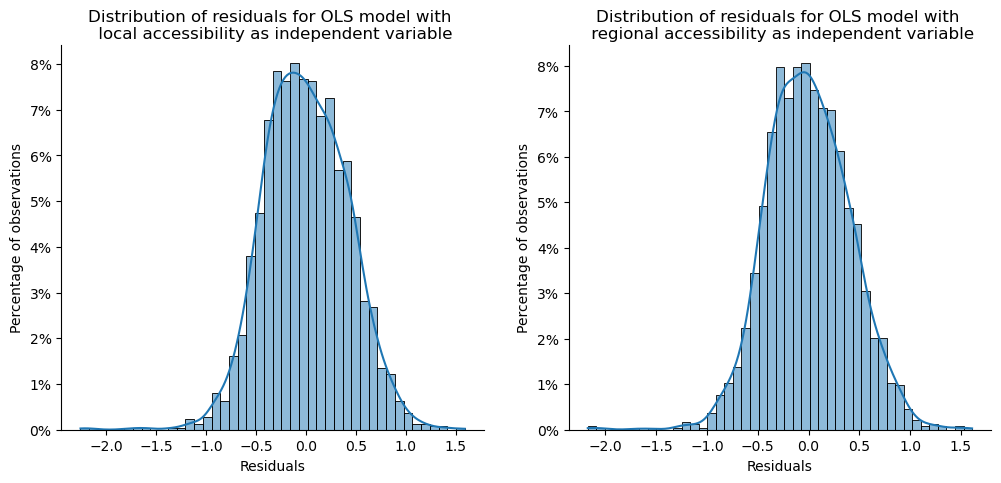

In [11]:
# histogram of the residuals
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(ols_model_1.resid, kde=True, ax=ax[0], stat='probability')
ax[0].set_title('Distribution of residuals for OLS model with \n local accessibility as independent variable',wrap=True)
sns.histplot(ols_model_2.resid, kde=True, ax=ax[1], stat='probability')
ax[1].set_title('Distribution of residuals for OLS model with \n regional accessibility as independent variable',wrap=True)

for i in range(2):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_ylabel('Percentage of observations')
    ax[i].set_xlabel('Residuals')
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

if save_fig:
    fig.savefig('figs/Ols_residuals.png', dpi=300)


## Spatial regression

In [12]:
postalcodePrice = df.groupby('postalcode')['perAreaPrice'].mean().to_dict()
df['postalcode_avg_price'] = np.log(df['postalcode'].map(postalcodePrice))

x_vars = public_transport[1:2] + control_variables[0:] + ['postalcode_avg_price']
y_var = target_variables[0]
print(f'y: log({y_var}) \n x: {x_vars}')

spatial_model = ols_regression(df, x_vars=x_vars, y_var=y_var, 
                       y_log=True,constant=True,verbose=0)

print(f'R^2: {spatial_model.rsquared:.3f}, Adj. R^2: {spatial_model.rsquared_adj:.3f}')

spatial_output = transform_output(res=spatial_model, x_vars=x_vars, constant=True)#spatial_model.summary()
spatial_output

y: log(priceCash) 
 x: ['no_of_tot_stops_in_500m', 'housingArea', 'isAppartment', 'hasBalcony', 'hasElevator', 'hasTerrace', 'energyLabel_cat', 'postalcode_avg_price']
R^2: 0.771, Adj. R^2: 0.770


,coef,std err,t-values,p-values,conf-int1,conf-int2,significant
const,5.071313,0.239148,21.205784,8.445082e-100,4.602592,5.540033,*
no_of_tot_stops_in_500m,0.012517,0.002871,4.359683,1.302511e-05,0.006890,0.018145,*
housingArea,0.006830,0.000345,19.781443,4.302025e-87,0.006154,0.007507,*
isAppartment,-0.390397,0.030812,-12.670366,8.631062e-37,-0.450787,-0.330007,*
hasBalcony,0.083751,0.021424,3.909232,9.258993e-05,0.041761,0.125742,*
hasElevator,0.112981,0.026220,4.309021,1.639785e-05,0.061591,0.164370,*
hasTerrace,0.101544,0.029856,3.401134,6.710688e-04,0.043027,0.160060,*
energyLabel_cat,-0.048701,0.007904,-6.161219,7.218692e-10,-0.064193,-0.033208,*
postalcode_avg_price,0.907816,0.023648,38.388709,0.000000e+00,0.861467,0.954165,*


## Quantile regression

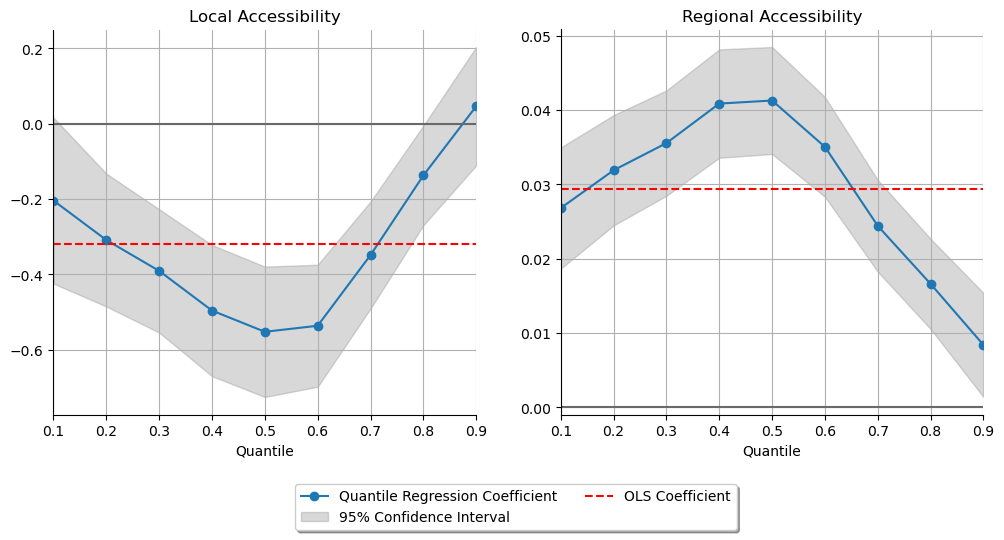

In [13]:
# Your existing data setup
Y_var = target_variables[0]
# Initialize quantile values
quantiles = np.arange(0.1, 1, 0.1)

# Calculate the coefficient and confidence intervals for each quantile
def get_confidence(model, coeff_str:str, alpha=0.05):
    coeffs = []
    lower_bounds = []
    upper_bounds = []
    transforms = []
    for q in quantiles:
        quantile_fit = model.fit(q=q,max_iter=5000)
        transforms.append(transform_output(quantile_fit, control_variables + [coeff_str], constant=True))
        
        # Extract coefficient and confidence intervals for 'closest_busstop_in_km'
        coeff = quantile_fit.params[coeff_str]
        conf_int = quantile_fit.conf_int(alpha=0.05)  # 95% confidence intervals
        lower_bound = conf_int.loc[coeff_str][0]
        upper_bound = conf_int.loc[coeff_str][1]
        
        coeffs.append(coeff)
        lower_bounds.append(lower_bound)
        upper_bounds.append(upper_bound)
    return coeffs, lower_bounds, upper_bounds, transforms

fig, ax = plt.subplots(1, 2, figsize=(12, 5))


transforms = [None, None]
for i, (pubVar,olsModel,label) in enumerate(zip(public_transport,[ols_model_1,ols_model_2],['Local Accessibility','Regional Accessibility'])):

    ols_coeffs = olsModel.params[pubVar]
    ols_conf_int = olsModel.conf_int(alpha=0.05).loc[pubVar]
    
    X = df[control_variables + [pubVar]]
    Y = np.log(df[Y_var])
    model = sm.QuantReg(Y, sm.add_constant(X))
    
    coeffs, lower_bounds, upper_bounds,transforms[i] = get_confidence(model, pubVar)

    # add quantile regression line and confidence intervals
    ax[i].plot(quantiles, coeffs, marker='o', label='Quantile Regression Coefficient')
    ax[i].fill_between(quantiles, lower_bounds, upper_bounds, color='grey', alpha=0.3, label='95% Confidence Interval')

    # add OLS regression line and confidence intervals
    ax[i].axhline(ols_coeffs, color='r', linestyle='--', label='OLS Coefficient')
    # ax[i].fill_between([0, 1], ols_conf_int[0], ols_conf_int[1], color='r', alpha=0.1, label='OLS 95% Confidence Interval')


    # seetings
    ax[i].set_xlabel('Quantile')
    ax[i].set_title(f'{label}')
    ax[i].grid()
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    # add a zero line
    ax[i].axhline(0, color='#696969', linestyle='-')
    ax[i].set_xlim((0.1,0.9))

handles, labels = ax[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(0.70, -0.015), ncol=2,fancybox=True, shadow=True)

if save_fig:
    fig.savefig('figs/quantile_regression_output.png', dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight')

## To latex

In [14]:
for i in range(len(transforms)):
    for j in range(len(transforms[i])):
        transforms[i][j].columns = pd.MultiIndex.from_product([[f'Q {j}'], transforms[i][j].columns])
        
ols1_output_mult = ols1_output.copy()
ols2_output_mult = ols2_output.copy()
spatial_output_mult = spatial_output.copy()

ols1_output_mult.columns = pd.MultiIndex.from_product([['OLS'], ols1_output.columns])
ols2_output_mult.columns = pd.MultiIndex.from_product([['IV'], ols2_output.columns])
spatial_output_mult.columns = pd.MultiIndex.from_product([['Spatial'], spatial_output.columns])


if save_fig:
    multiple_to_latex([ols1_output_mult,ols2_output_mult,
                    spatial_output_mult],
                    ['OLS 1','OLS 2','IV','SPATIAL'], 
                    filename='combined_output.tex')

    multiple_to_latex([transforms[0][i] for i in range(len(transforms[0]))],
                    [f'Quantile {i}' for i in range(len(transforms[0]))], 
                    filename='combined_output_quantile_1.tex')

    multiple_to_latex([transforms[1][i] for i in range(len(transforms[1]))],
                    [f'Quantile {i}' for i in range(len(transforms[1]))], 
                    filename='combined_output_quantile_2.tex')

### Check for multicollinearity via VIF and Correlation matrix

In [15]:
# Checking for multicollinearity
x_vars = public_transport[0:1] + control_variables[:]
vif_data = pd.DataFrame()
vif_data["feature"] = x_vars
vif_data['VIF'] = [variance_inflation_factor(df[x_vars], i) for i in range(len(x_vars))]
print(vif_data)

              feature       VIF
0  clost_public_trans  3.046997
1         housingArea  3.515708
2        isAppartment  3.032595
3          hasBalcony  2.806448
4         hasElevator  2.508274
5          hasTerrace  1.085863
6     energyLabel_cat  3.443148


## Plots

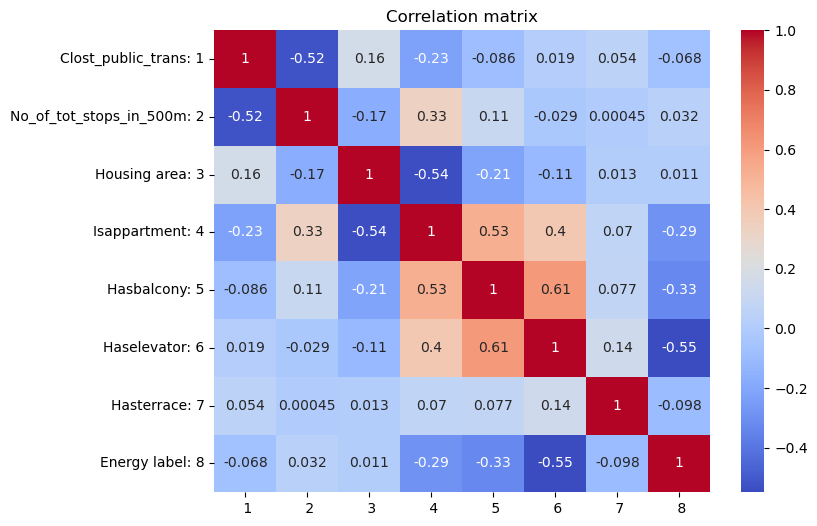

In [16]:
corr = df[public_transport[:] + control_variables[0:]].corr()
corr.rename(index=
            {'closest_busstop_in_km':'Closest busstop in km', 
             'no_of_stops_in_500m':'No. of stops in 500m', 
             'no_of_unique_stops_in_500m':'No. of lines in 500m',
             'housingArea':'Housing area',
             'ameneties':'Ameneties',
             'yearBuilt':'Year built',
             'beddroom2-':'Below 3 rooms',
             'beedroom3':'Exactly 3 rooms',
             'beedroom4+':'Above 3 rooms',
             'energyLabel_cat':'Energy label',
             'addressType_cat':'Property type'
             }, inplace=True)
corr.index = [f'{x.capitalize()}: {i+1}' for i, x in enumerate(corr.index)]
corr.columns = [x.split(':')[1] for x in corr.index]


fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm',ax=ax)
ax.set_ylabel('')
ax.set_title('Correlation matrix')

if save_fig:
    fig.savefig('figs/correlation_matrix.png', dpi=300)

**Plotting the zip code average prices**

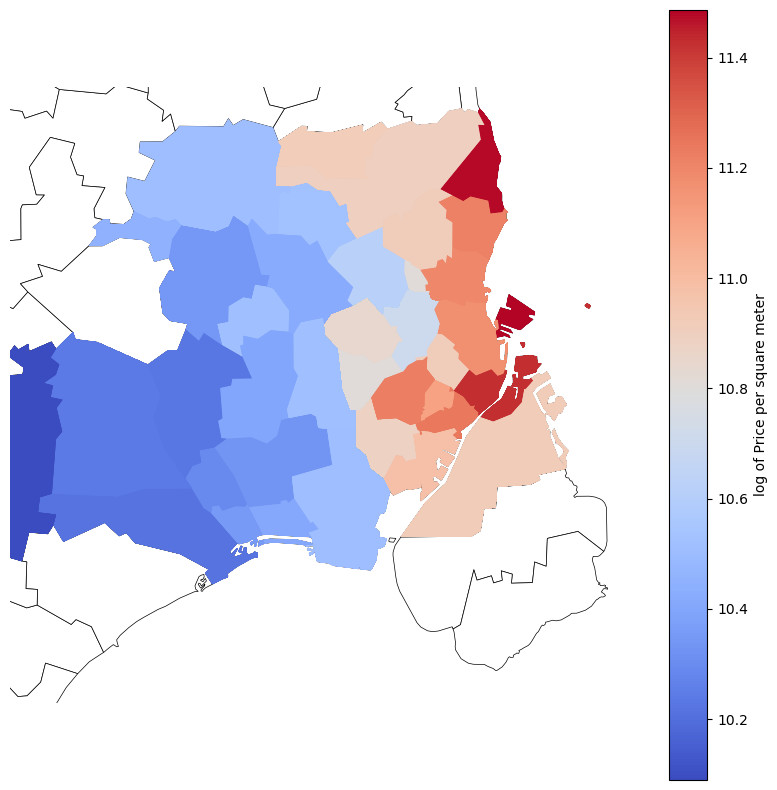

In [17]:
# Creating a copy of the dataframe for new use
df_zip_code = df.copy()
# Convert the postalcode to integer to categorize
df_zip_code['postalcode'] = df_zip_code['postalcode'].astype(int)
# Renaming the postalcode to categories to match with GeoJSON file.
def categorize_zipcode(zipcode):
    if 1000 <= zipcode <= 1499:
        return "1000-1499"
    elif 1500 <= zipcode <= 1799:
        return "1500-1799"
    elif 1800 <= zipcode <= 1999:
        return "1800-1999"
    else:
        return zipcode

###### NEW CELL
# Apply the function to the postalcode column and change into string
df_zip_code['postalcode'] = df_zip_code['postalcode'].apply(categorize_zipcode)
df_zip_code['postalcode'] = df_zip_code['postalcode'].astype(str)

postalcodePrice = df_zip_code.groupby('postalcode')['perAreaPrice'].mean().to_dict()
df_zip_code['postalcode_avg_price'] = df_zip_code['postalcode'].map(postalcodePrice)

###### NEW CELL
# Load a shapefile of Copenhagen's zip code boandaries
gdf = gpd.read_file('data/postal_codes/postal_codes.geojson')

# Rename the column to match the column in the df
gdf = gdf.rename(columns={'postal_code':'postalcode'})
# Taking logs of the price
df_zip_code['log_postalcode_avg_price']=np.log(df_zip_code['postalcode_avg_price'])
# Merge the two dataframes
merged =gdf.merge(df_zip_code, on='postalcode', how='right')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)
merged.plot(column='log_postalcode_avg_price', ax=ax, legend=True, cmap='coolwarm', legend_kwds={'label': "log of Price per square meter"})
ax.set_ylim(55.54, 55.82)
ax.set_xlim(12.20, 12.7)
plt.axis('off')
plt.show()
